In [44]:
import numpy as np
import pandas as pd
import os
import re
import nltk
import keras
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

#from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#nltk.download("vader_lexicon")

In [62]:
# Import cleaned, by-round, combined study dataset

df = pd.read_csv("PoliticalStances_Combined_ByRound", converters = {'free_response_r1': str, 'free_response_r2': str})

#Create mismatch df 
df = df[df['round_number']==1]

df_mm = df[(df['match']==0)]
df_m = df[(df['match']==1)]
df_c = df[(df['match']==2)]

df_list = [df_mm, df_m, df_c]

In [24]:
def format_dfs(df, label_no):
    df = df[['match', 'free_response_2', 'cause', 'liberal']].fillna("empty")
    df.rename(columns={'free_response_2': 'response'}, inplace=True)
    labels = {label_no: 'mismatch'}
    df['label'] = df['match']
    df['label'].replace(labels, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

df_mm = format_dfs(df_mm, 0)
df_m = format_dfs(df_m, 1)
df_c = format_dfs(df_c, 2)

In [51]:
# Replace standardized text using RegEx, set words to lowercase

from nltk.corpus import stopwords

stop_words = stopwords.words("english")

def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ", regex=True)
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.replace(r"%", "")
    df[text_field] = df[text_field].str.replace(r"[0-9]+", "", regex=True)
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].str.strip()
    df[text_field] = df[text_field].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    return df

df_mm_clean = standardize_text(df_mm, "response")
df_m_clean = standardize_text(df_m, "response")
df_c_clean = standardize_text(df_c, "response")

#print(df_mm_clean.groupby("label").count())

In [26]:
## Pre-processing the data
# Tokenizing responses

from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

def tokenize_responses(df, token_field, text_field):
    df[token_field] = df[text_field].apply(tokenizer.tokenize)
    return df[token_field]

df_mm_clean["tokens"] = tokenize_responses(df_mm_clean, "tokens", "response")
df_m_clean["tokens"] = tokenize_responses(df_m_clean, "tokens", "response")
df_c_clean["tokens"] = tokenize_responses(df_c_clean, "tokens", "response")

In [27]:
# print("FULL CORPUS")

all_words_mm = [word for tokens in df_mm_clean["tokens"] for word in tokens]
sentence_lengths_mm = [len(tokens) for tokens in df_mm_clean["tokens"]]
VOCAB_mm = sorted(list(set(all_words_mm)))
# print("MISMATCH: %s words total, with a vocabulary size of %s" % (len(all_words_mm), len(VOCAB_mm)))
# print("Mean sentence length is %s" % round(np.mean(sentence_lengths_mm), 2))
# print(" ")

all_words_m = [word for tokens in df_m_clean["tokens"] for word in tokens]
sentence_lengths_m = [len(tokens) for tokens in df_m_clean["tokens"]]
VOCAB_m = sorted(list(set(all_words_m)))
# print("MATCH: %s words total, with a vocabulary size of %s" % (len(all_words_m), len(VOCAB_m)))
# print("Mean sentence length is %s" % round(np.mean(sentence_lengths_m), 2))
# print(" ")

all_words_c = [word for tokens in df_c_clean["tokens"] for word in tokens]
sentence_lengths_c = [len(tokens) for tokens in df_c_clean["tokens"]]
VOCAB_c = sorted(list(set(all_words_c)))
# print("CONTROL: %s words total, with a vocabulary size of %s" % (len(all_words_c), len(VOCAB_c)))
# print("Mean sentence length is %s" % round(np.mean(sentence_lengths_c), 2))


FULL CORPUS
MISMATCH: 2562 words total, with a vocabulary size of 730
Mean sentence length is 8.51
 
MATCH: 2727 words total, with a vocabulary size of 756
Mean sentence length is 9.0
 
CONTROL: 1914 words total, with a vocabulary size of 606
Mean sentence length is 9.57


In [28]:
# Focus on Mismatch Condition
# Corpus to List / Train-Test Split

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import itertools
from sklearn.metrics import confusion_matrix

# Send Corpuses to Lists
list_corpus_mm = df_mm_clean["response"].tolist()
list_labels_mm = df_mm_clean["liberal"].tolist()

# Train Test Split for Full Corpus
X_train_mm, X_test_mm, y_train_mm, y_test_mm = train_test_split(list_corpus_mm, list_labels_mm, test_size=0.2, 
                                                                                random_state=1)


In [29]:
# Vectorize (bigrams) train and text sets 

cv_mm = CountVectorizer(binary=True, ngram_range=(1, 2))
X_train_counts_mm = cv_mm.fit_transform(X_train_mm)
X_test_counts_mm = cv_mm.transform(X_test_mm)

In [30]:
# Fitting a classifier (Logistic Regression)

clf_mm = LogisticRegression()
model_names = ["Mismatched"]
index = 0

def c_values_accuracy(model, train_counts, train_target, index):
    for c in [0.01, 0.05, 0.25, 0.5, 1, 5, 10, 20]:
        if c == 0.01:
            print ("    ")
            print (model_names[index] + " Model")
            print ("    ")
        model = LogisticRegression(C=c)
        model.fit(train_counts, train_target)
        print ("Accuracy for C=%s: %s" 
               % (c, accuracy_score(train_target, model.predict(train_counts))))
        
        
        
# c_values_accuracy(clf_mm, X_train_counts_mm, y_train_mm, 0)

    
Mismatched Model
    
Accuracy for C=0.01: 0.6708333333333333
Accuracy for C=0.05: 0.8
Accuracy for C=0.25: 0.9375
Accuracy for C=0.5: 0.9708333333333333
Accuracy for C=1: 0.975
Accuracy for C=5: 0.9875
Accuracy for C=10: 0.9875
Accuracy for C=20: 0.9875


In [31]:
# Fit logistic regression with c=1 penalty term (accuracy > 0.95 in train set)

clf_mm = LogisticRegression(C=1, random_state=2)
clf_mm.fit(X_train_counts_mm, y_train_mm)
y_predicted_counts_mm = clf_mm.predict(X_test_counts_mm)

In [32]:
# Model Evaluation

def get_metrics(y_test, y_predicted):
    #true positives / (TP + FP)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                average='weighted')
    #TP / (TP + FN)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                                average='weighted')
    
    #Harmonic mean of precision and recall:
    f1 = f1_score(y_test, y_predicted, pos_label=None,
                                average='weighted')
    
    #TP + TN / Total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test_mm, y_predicted_counts_mm)
# print("Mismatched Model")
# print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))
# print(" ")

Mismatched Model
accuracy = 0.754, precision = 0.745, recall = 0.754, f1 = 0.738
 


In [33]:
# Plot confusion matrix

def plot_confusion_matrix(cm, classes, normalize=False,
                         title='Confusion matrix', 
                         cmap=plt.cm.winter):
    if normalize: 
        cm = cm.astype('float') / cm.sum(axis=1)[:np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

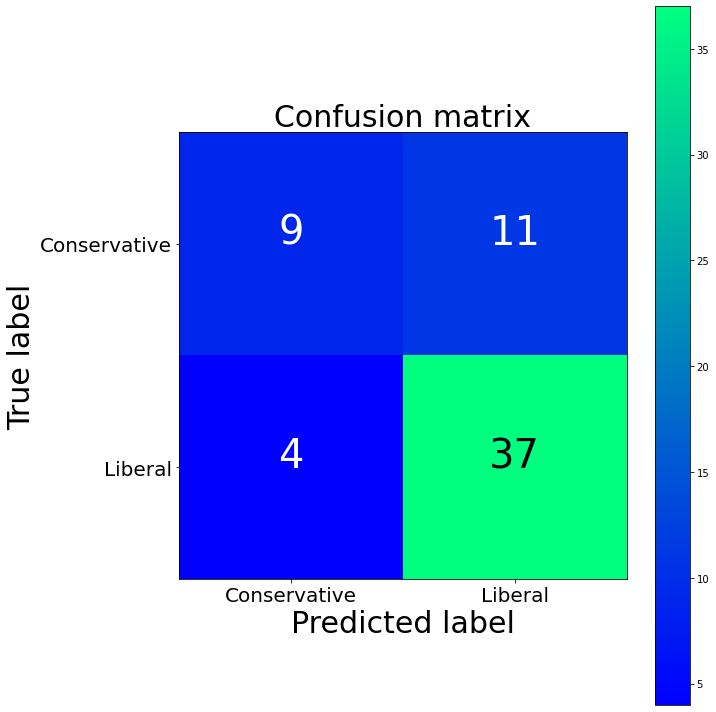

In [34]:
# cm = confusion_matrix(y_test_mm, y_predicted_counts_mm)
# fig = plt.figure(figsize=(10, 10))
# plot = plot_confusion_matrix(cm, classes=['Conservative','Liberal'], normalize=False, title='Confusion matrix')
# plt.show()
# print(cm)

In [48]:
# Show words with largest importance factor for each group

def top_10_words(c_vect, model):
    top_words_list = []
    feature_to_coef = {
        word: coef for word, coef in zip(
            c_vect.get_feature_names(), model.coef_[0]
        )
    }
    for best_positive in sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:10]:
        top_words_list.append(best_positive)
        
    for best_negative in sorted(feature_to_coef.items(), key=lambda x: x[1])[:10]:
        top_words_list.append(best_negative)

    return top_words_list
    

In [49]:
word_list = top_10_words(cv_mm, clf_mm)
word_df = pd.DataFrame(word_list, columns=['Words', 'Importance Factor'])